# Fourier Space Filtering Based on FRC

Here I investigate how FRC resolution measurement can be combined with frequency domain filtering.

In [12]:
%matplotlib inline

import os
import numpy as np

import supertomo.ui.plots.image as showim
from supertomo.psf import psfgen

import supertomo.data.io.read as imread
import supertomo.processing.image as imops
from supertomo.data.containers.image import Image


import supertomo.analysis.resolution.fourier_ring_correlation as frc
import supertomo.analysis.resolution.analysis as frc_analysis
import supertomo.data.io.read as read
from supertomo.data.containers.fourier_correlation_data import FourierCorrelationDataCollection
import supertomo.analysis.resolution.analysis as fsc_analysis
import supertomo.processing.image as imops
from math import sqrt

import supertomo.ui.plots.frc as frcplots

from supertomo.processing.fft_filters import fft_filter



## Load an image

The image is from a Nikon A1 confocal system, of a Tubulin stained HeLa cell. 

In [13]:
# Image
data_dir = "/Users/sami/Temp"
filename = "FRC_GaAsP_AU04__.nd2"
full_path = os.path.join(data_dir, filename)

image = imread.get_image(full_path)

image_copy = image.copy()
spacing = image.spacing
print "The image dimensions are {} and spacing {} um.".format(image.shape, image.spacing)

image = Image(image - image.min(), image.spacing)

The image dimensions are (512, 512) and spacing [0.05179004745018662, 0.05179004745018662] um.


In [14]:
from supertomo.ui import deconvolution_options as options
args_list = ("image psf"  
             " --resolution-threshold-criterion=half-bit").split()
            
args = options.get_deconvolve_script_options(args_list)

## Calculate resolution

Here I estimate the resolution of the image with the single-image FRC method. 

Fit starts at 0.625
Optimization terminated successfully.
         Current function value: 0.000040
         Iterations: 10
         Function evaluations: 20


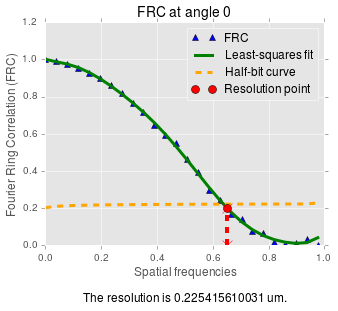

In [15]:
data = FourierCorrelationDataCollection()

image1, image2 = imops.checkerboard_split(image)

frc_task = frc.FRC(image1, image2, args.d_bin)
data[0] = frc_task.execute()
                 

analyzer = fsc_analysis.FourierCorrelationAnalysis(data, image1.spacing[0], args)
results = analyzer.execute()

plotter = frcplots.FourierDataPlotter(results)
plotter.plot_one(0)

## Low-Pass filtering

In the first filtering alternative I just simply remove all the frequencies beyond the cut-off point. 

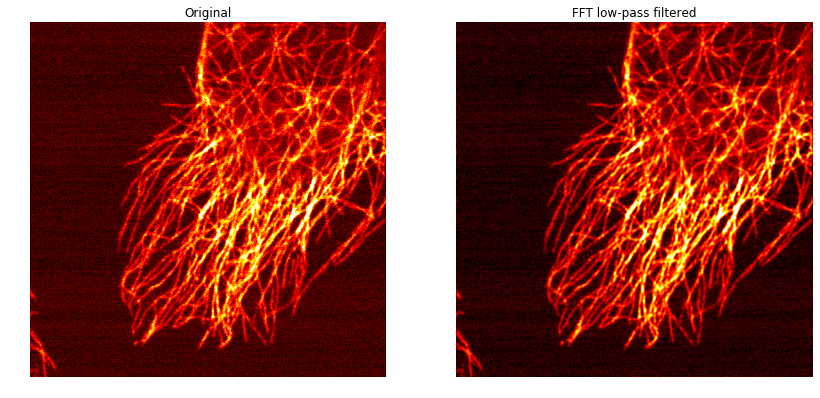

The resolution cut-off point is at 0.459507196002


In [16]:

threshold_point = results[0].resolution['resolution-point'][1]/np.sqrt(2)

result = fft_filter(image, 
                    threshold_point)

showim.display_2d_images(imops.enhance_contrast(image, percent_saturated=0.3), 
                         imops.enhance_contrast(result, percent_saturated=0.3),
                         image1_title="Original",
                         image2_title="FFT low-pass filtered")

print "The resolution cut-off point is at {}".format(threshold_point)

## To Do

- Wiener filter
- Gaussian/Butterworth low-pass to see if there's a difference.